## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 175kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.8MB/s]


In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [13]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)

In [14]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------


Your experiments come here:

In [16]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

from torch.utils.data import random_split, DataLoader

val_size = 5000
train_size = len(fmnist_dataset_train) - val_size
train_ds, val_ds = random_split(fmnist_dataset_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2)

def eval_loader(model, loader):
    model.eval()
    total_loss, total_correct, total = 0.0,0,0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_func(logits,y)
            total_loss += loss.item()*x.size(0)
            total_correct += (logits.argmax(dim=1) == y).sum().item()
            total += x.size(0)
    return total_loss/total, total_correct/total

epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total = 0.0,0,0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        logits = model(x)
        loss = loss_func(logits, y)
        loss.backward()
        opt.step()

        total_loss += loss.item()*x.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)

    train_loss = total_loss /total
    train_acc = total_correct /total
    val_loss, val_acc = eval_loader(model,val_loader)

    train_losses.append(train_loss); train_accs.append(train_acc)
    val_losses.append(val_loss); val_accs.append(val_acc)

    print(f"epoch {epoch+1}: train acc={train_acc:.4f}, val acc={val_acc:.4f}")

test_loss,test_acc = eval_loader(model,test_loader)
print("test accuracy:",test_acc)

epoch 1: train acc=0.8103, val acc=0.8490
epoch 2: train acc=0.8655, val acc=0.8424
epoch 3: train acc=0.8784, val acc=0.8638
epoch 4: train acc=0.8884, val acc=0.8752
epoch 5: train acc=0.8948, val acc=0.8700
epoch 6: train acc=0.8978, val acc=0.8846
epoch 7: train acc=0.9052, val acc=0.8882
epoch 8: train acc=0.9077, val acc=0.8854
epoch 9: train acc=0.9124, val acc=0.8910
epoch 10: train acc=0.9159, val acc=0.8836
test accuracy: 0.8858


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [21]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)

In [22]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 4096]      16,781,312
              ReLU-5                 [-1, 4096]               0
            Linear-6                 [-1, 2048]       8,390,656
              ReLU-7                 [-1, 2048]               0
            Linear-8                   [-1, 10]          20,490
Total params: 28,407,818
Trainable params: 28,407,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 108.37
Estimated Total Size (MB): 108.53
----------------------------------------------------------------


In [27]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

small_train_size = 1000
train_ds_small, _ = random_split(fmnist_dataset_train,
    [small_train_size, len(fmnist_dataset_train)-small_train_size],
    generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds_small, batch_size=128, shuffle=True)

def eval_loader(model, loader):
    model.eval()
    total_loss, total_correct, total = 0.0,0,0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_func(logits,y)

            total_loss += loss.item() * x.size(0)
            total_correct += (logits.argmax(dim=1) == y).sum().item()
            total += x.size(0)
    return total_loss/total, total_correct/total

epochs = 40
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total = 0.0,0,0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        logits = model(x)
        loss = loss_func(logits,y)
        loss.backward()
        opt.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)

    train_loss = total_loss /total
    train_acc = total_correct /total

    val_loss,val_acc = eval_loader(model,val_loader)

    train_losses.append(train_loss); train_accs.append(train_acc)
    val_losses.append(val_loss); val_accs.append(val_acc)

    print(f"epoch {epoch+1}: train acc={train_acc:.4f}, val acc={val_acc:.4f}")

test_loss,test_acc = eval_loader(model,test_loader)
print("test accuracy:",test_acc)

epoch 1: train acc=0.3550, val acc=0.6076
epoch 2: train acc=0.6310, val acc=0.7294
epoch 3: train acc=0.7370, val acc=0.7418
epoch 4: train acc=0.7710, val acc=0.7612
epoch 5: train acc=0.7980, val acc=0.7696
epoch 6: train acc=0.8210, val acc=0.7954
epoch 7: train acc=0.8660, val acc=0.7970
epoch 8: train acc=0.8840, val acc=0.7888
epoch 9: train acc=0.8600, val acc=0.7790
epoch 10: train acc=0.8730, val acc=0.8160
epoch 11: train acc=0.9030, val acc=0.8176
epoch 12: train acc=0.9120, val acc=0.7864
epoch 13: train acc=0.9010, val acc=0.8164
epoch 14: train acc=0.9090, val acc=0.7986
epoch 15: train acc=0.9170, val acc=0.7902
epoch 16: train acc=0.9220, val acc=0.7696
epoch 17: train acc=0.9400, val acc=0.7900
epoch 18: train acc=0.9180, val acc=0.7996
epoch 19: train acc=0.9370, val acc=0.7964
epoch 20: train acc=0.9570, val acc=0.8128
epoch 21: train acc=0.9360, val acc=0.7958
epoch 22: train acc=0.9320, val acc=0.7992
epoch 23: train acc=0.9430, val acc=0.8118
epoch 24: train acc=

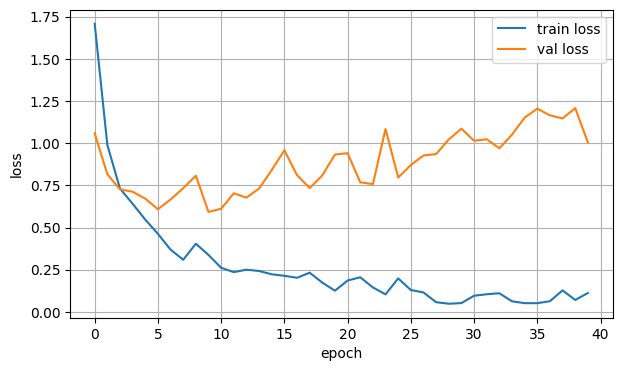

In [28]:
plt.figure(figsize=(7,4))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend(); plt.grid(True)
plt.show()

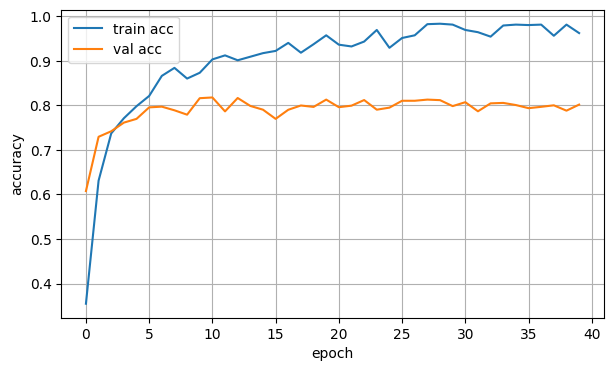

In [29]:
plt.figure(figsize=(7,4))
plt.plot(train_accs, label="train acc")
plt.plot(val_accs, label="val acc")
plt.legend(); plt.grid(True); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.show()

При уменьшении размера обучающей выборки и увеличении сложности модели видим переобучение. Точность на обучающей выборке продолжает расти, а качество на валидационной и тестовой выборках не меняется или ухудшается. Это также подтверждается ростом validation loss при пснижении train loss.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [31]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(2048, num_classes)
        )

    def forward(self, inp):
        return  self.model(inp)

In [32]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
           Dropout-5                 [-1, 4096]               0
            Linear-6                 [-1, 2048]       8,390,656
       BatchNorm1d-7                 [-1, 2048]           4,096
              ReLU-8                 [-1, 2048]               0
           Dropout-9                 [-1, 2048]               0
           Linear-10                   [-1, 10]          20,490
Total params: 11,638,794
Trainable params: 11,638,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 44.40
Esti

In [33]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

def eval_loader(model, loader):
    model.eval()
    total_loss, total_correct, total = 0.0,0,0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_func(logits,y)
            total_loss += loss.item()*x.size(0)
            total_correct += (logits.argmax(dim=1) == y).sum().item()
            total += x.size(0)
    return total_loss/total, total_correct/total

epochs = 40
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total = 0.0,0,0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        logits = model(x)
        loss = loss_func(logits, y)
        loss.backward()
        opt.step()

        total_loss += loss.item()*x.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)

    train_loss = total_loss /total
    train_acc = total_correct /total

    val_loss,val_acc = eval_loader(model,val_loader)

    train_losses.append(train_loss); train_accs.append(train_acc)
    val_losses.append(val_loss); val_accs.append(val_acc)

    print(f"epoch {epoch+1}: train acc={train_acc:.4f}, val acc={val_acc:.4f}")

test_loss,test_acc = eval_loader(model,test_loader)
print("test accuracy:",test_acc)

epoch 1: train acc=0.6120, val acc=0.6318
epoch 2: train acc=0.7850, val acc=0.7466
epoch 3: train acc=0.8490, val acc=0.7788
epoch 4: train acc=0.8770, val acc=0.7940
epoch 5: train acc=0.9030, val acc=0.7874
epoch 6: train acc=0.9130, val acc=0.7918
epoch 7: train acc=0.9330, val acc=0.7946
epoch 8: train acc=0.9360, val acc=0.7820
epoch 9: train acc=0.9310, val acc=0.7824
epoch 10: train acc=0.9430, val acc=0.7902
epoch 11: train acc=0.9510, val acc=0.7938
epoch 12: train acc=0.9370, val acc=0.7792
epoch 13: train acc=0.9530, val acc=0.7958
epoch 14: train acc=0.9550, val acc=0.7928
epoch 15: train acc=0.9640, val acc=0.7702
epoch 16: train acc=0.9630, val acc=0.7884
epoch 17: train acc=0.9520, val acc=0.7790
epoch 18: train acc=0.9610, val acc=0.7656
epoch 19: train acc=0.9740, val acc=0.7874
epoch 20: train acc=0.9710, val acc=0.7764
epoch 21: train acc=0.9740, val acc=0.7864
epoch 22: train acc=0.9750, val acc=0.7824
epoch 23: train acc=0.9750, val acc=0.7788
epoch 24: train acc=

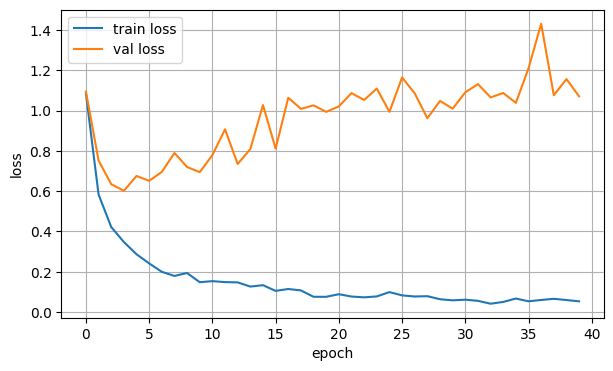

In [34]:
plt.figure(figsize=(7,4))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend(); plt.grid(True)
plt.show()

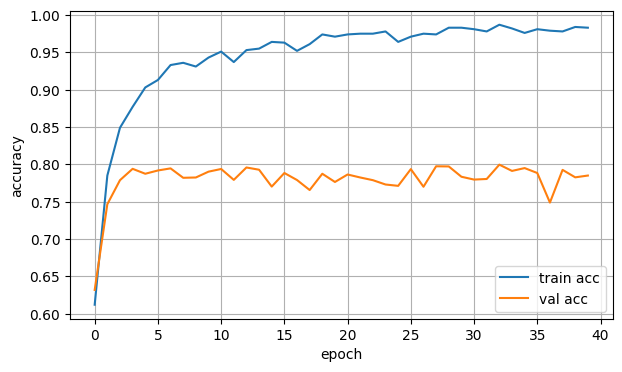

In [35]:
plt.figure(figsize=(7,4))
plt.plot(train_accs, label='train acc')
plt.plot(val_accs, label='val acc')
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.legend(); plt.grid(True)
plt.show()

### Conclusions:
Добавление BatchNorm и Dropout частично снижает переобучение. Обучение стало более стабильным, рост train accuracy замедлился, а validation accuracy перестала деградировать с ростом числа эпох.
Однако из-за малого объёма данных полностью устранить переобучение не удалось.